In [1]:
# Libraries.
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")

In [2]:
# Input files.
results_fn = 'all_utterances.json'

In [3]:
# Function definitions.

# Get word counts from list of lines.
def get_wc_from_lines(lines):
    wc = {}
    for line in lines:
        doc = nlp(line)
        for token in doc:
            token = str(token).lower()
            if token not in wc:
                wc[token] = 0
            wc[token] += 1
    return wc

# Get lenghts from lines.
def get_lens_from_lines(lines):
    lens = []
    m = 0
    ml = None
    for line in lines:
        doc = nlp(line)
        lens.append(len(doc))
        if len(doc) > m:
            m = len(doc)
            ml = line
    return lens, m, ml

# Flip the entries of a dictionary and return the result.
def flip_dict(d):
    g = {}
    for key in d:
        if d[key] not in g:
            g[d[key]] = []
        g[d[key]].append(key)
    return g

In [4]:
# Read input file.
with open(results_fn, 'r') as f:
    records = []
    for line in f.readlines():
        records.append(json.loads(line))
    df = pd.DataFrame.from_records(records)
print("size of df: %d" % len(df))

size of df: 13188


In [5]:
# Get lengths.
cmd_len = {}
for summary_type, tasks in [["all", ['1', '2', '3']],
                            ["nav", ['1']],
                            ["del", ['2']],
                            ["rel", ['3']]]:       
    cmd_len[summary_type], m, ml = get_lens_from_lines(
        df.loc[df['task'].isin(tasks)].loc[df['type'] == "CMD"]['msg'])

    print("%s: command len avg %.2f; len std %.2f; min %d; max %d; max line:\n'%s'\n" %
          (summary_type, np.average(cmd_len[summary_type]), np.std(cmd_len[summary_type]),
           np.min(cmd_len[summary_type]), np.max(cmd_len[summary_type]), ml))

all: command len avg 8.20; len std 6.43; min 0; max 71; max line:
'begin in the conference room pick up the object exit that room and go left in the hallway pass the offices the pod and go right at the corner follow the hallway along the lab turn left at the corner go forward in the hallway pass the pod the conference room the lounge office r office b and office p enter the pod on the left and place the object there'

nav: command len avg 6.36; len std 4.03; min 0; max 34; max line:
'robot you should travel down the hall until you pass the office of dr sybil smalt which will be on your left and then enter the long lab at the end of the hall'

del: command len avg 6.59; len std 3.46; min 0; max 29; max line:
'go grab the bottle on the table open it and take out 5 pills out then put 1 pill back to the bottle and put the cap back on'

rel: command len avg 11.21; len std 8.65; min 0; max 71; max line:
'begin in the conference room pick up the object exit that room and go left in the hallwa

In [6]:
# Get vocabularies and wordcounts.
all_wc = {}
all_voc = {}
train_wc = {}
train_voc = {}
test_wc = {}
test_voc = {}
cmd_wc = {}
cmd_voc = {}
res_wc = {}
res_voc = {}
for summary_type, tasks in [["all", ['1', '2', '3']],
                            ["nav", ['1']],
                            ["del", ['2']],
                            ["rel", ['3']]]:
    print(summary_type, tasks)  # DEBUG
    
    train_wc[summary_type] = get_wc_from_lines(df.loc[df['task'].isin(tasks)].loc[df['cond'] == "TRAIN"]['msg'])
    train_voc[summary_type] = set(train_wc[summary_type].keys())
                                                      
    test_wc[summary_type] = get_wc_from_lines(df.loc[df['task'].isin(tasks)].loc[df['cond'] == "TEST"]['msg'])
    test_voc[summary_type] = set(test_wc[summary_type].keys())
    
    print("\ttrain voc: %d; test voc: %d; test\\train voc: %d" %
         (len(train_voc[summary_type]), len(test_voc[summary_type]),
          len(test_voc[summary_type].difference(train_voc[summary_type]))))
                            
    all_wc[summary_type] = get_wc_from_lines(df.loc[df['task'].isin(tasks)]['msg'])
    all_voc[summary_type] = set(all_wc[summary_type].keys())

    cmd_wc[summary_type] = get_wc_from_lines(df.loc[df['task'].isin(tasks)].loc[df['type'] == "CMD"]['msg'])
    cmd_voc[summary_type] = set(cmd_wc[summary_type].keys())

    res_wc[summary_type] = get_wc_from_lines(df.loc[df['task'].isin(tasks)].loc[df['type'] == "REP"]['msg'])
    res_voc[summary_type] = set(res_wc[summary_type].keys())

    print("%s:\tall voc: %d; cmd voc: %d; res voc: %d" %
          (summary_type, len(all_voc[summary_type]), len(cmd_voc[summary_type]), len(res_voc[summary_type])))
    

all ['1', '2', '3']
	train voc: 735; test voc: 802; test\train voc: 351
all:	all voc: 1086; cmd voc: 495; res voc: 976
nav ['1']
	train voc: 330; test voc: 378; test\train voc: 178
nav:	all voc: 508; cmd voc: 245; res voc: 448
del ['2']
	train voc: 420; test voc: 424; test\train voc: 170
del:	all voc: 590; cmd voc: 237; res voc: 548
rel ['3']
	train voc: 445; test voc: 525; test\train voc: 237
rel:	all voc: 682; cmd voc: 344; res voc: 595


In [7]:
# Convert wordcount dicts to count -> words.
all_cw = {st: flip_dict(all_wc[st]) for st in all_wc}
train_cw = {st: flip_dict(train_wc[st]) for st in train_wc}
test_cw = {st: flip_dict(test_wc[st]) for st in test_wc}
cmd_cw = {st: flip_dict(cmd_wc[st]) for st in cmd_wc}
res_cw = {st: flip_dict(res_wc[st]) for st in res_wc}

# Get total count sums.

all_wc_sum = {st: sum([all_wc[st][token] for token in all_wc[st]])
              for st in all_wc}
train_wc_sum = {st: sum([train_wc[st][token] for token in train_wc[st]])
              for st in train_wc}
test_wc_sum = {st: sum([test_wc[st][token] for token in test_wc[st]])
              for st in test_wc}
cmd_wc_sum = {st: sum([cmd_wc[st][token] for token in cmd_wc[st]])
              for st in cmd_wc}
res_wc_sum = {st: sum([res_wc[st][token] for token in res_wc[st]])
              for st in res_wc}

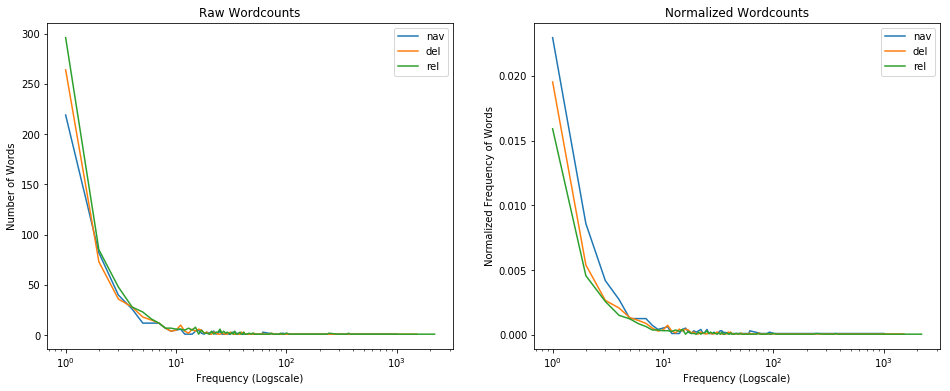

In [168]:
# Plot counts distributions.
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(16, 6))
counts = {st: np.array(sorted(all_cw[st].keys(), reverse=True))
          for st in all_cw}
fig.get_axes()[0].set_xscale('log')
fig.get_axes()[1].set_xscale('log')

ax1.title.set_text("Raw Wordcounts")
ax1.set(xlabel='Frequency (Logscale)', ylabel='Number of Words')
for st in counts:
    if st == 'all':
        continue
    sns.lineplot(x=np.array([k for k in all_cw[st]]),
                 y=np.array([len(all_cw[st][k]) for k in all_cw[st]]),
                 label=st, ax=ax1)

ax2.title.set_text("Normalized Wordcounts")
ax2.set(xlabel='Frequency (Logscale)', ylabel='Normalized Frequency of Words')
for st in counts:
    if st == 'all':
        continue
    sns.lineplot(x=np.array([k for k in all_cw[st]]),
                 y=np.array([len(all_cw[st][k]) / all_wc_sum[st] for k in all_cw[st]]),
                 label=st, ax=ax2)

plt.savefig("counts.pdf",bbox_inches='tight')
plt.show()

In [74]:
# Show some maxes and mins.
num_words = 5
for st in all_cw:
    print(st)
    print("\nall top counts---\n\t" +
          "\n\t".join([str(count) + ":\t" + ",".join(all_cw[st][count])
                     for count in counts[st][:num_words]]))
    print("\nall bottom counts---\n\t" +
          "\n\t".join([str(count) + ":\t" + ",".join(all_cw[st][count])
                     for count in reversed(counts[st][len(counts[st])-num_words:])]))

nav

all top counts---
	1004:	to
	895:	the
	786:	yes
	680:	no
	661:	go

all bottom counts---
	1:	direction,whom,noun,maybe,names,foward,describing,3rd,owned,form,designation,seven,deignated,chair,yo,directing,spot,displays,report,tp,shares,amount,sort,ealk,heard,represented,mallor,weight,nany,say,row,ok,hughes'sroom,dr.sybil,outs,behind,we,round,stapler,ahead,were,papers,park,proceed,people,her,eastern,accross,act,t,think,prepare,heaven,nickname,fastly,ethier,mustard,sheet,computer,edge,oh,very,malloy,stopping,him,marker,hugehes,different,message,clean,involves,specified,mark,certain,provide,self,do,order,perfect,pool,offic,longest,use,physical,negal,ignore,toward,for,simply,pick,areas,referring,structure,label,exactly,destination,le,pages,quantity,does,describe,sorry,copies,curd,contact,hhhflsfh,doing,nagles,type,long,sick,conversation,items,corridor,alphabet,reference,cake,tower,return,colour,today,job,bold,envelope,relocate,yess,item,cup,delivery,sandwitch, ,exact,tape,amd,help,near

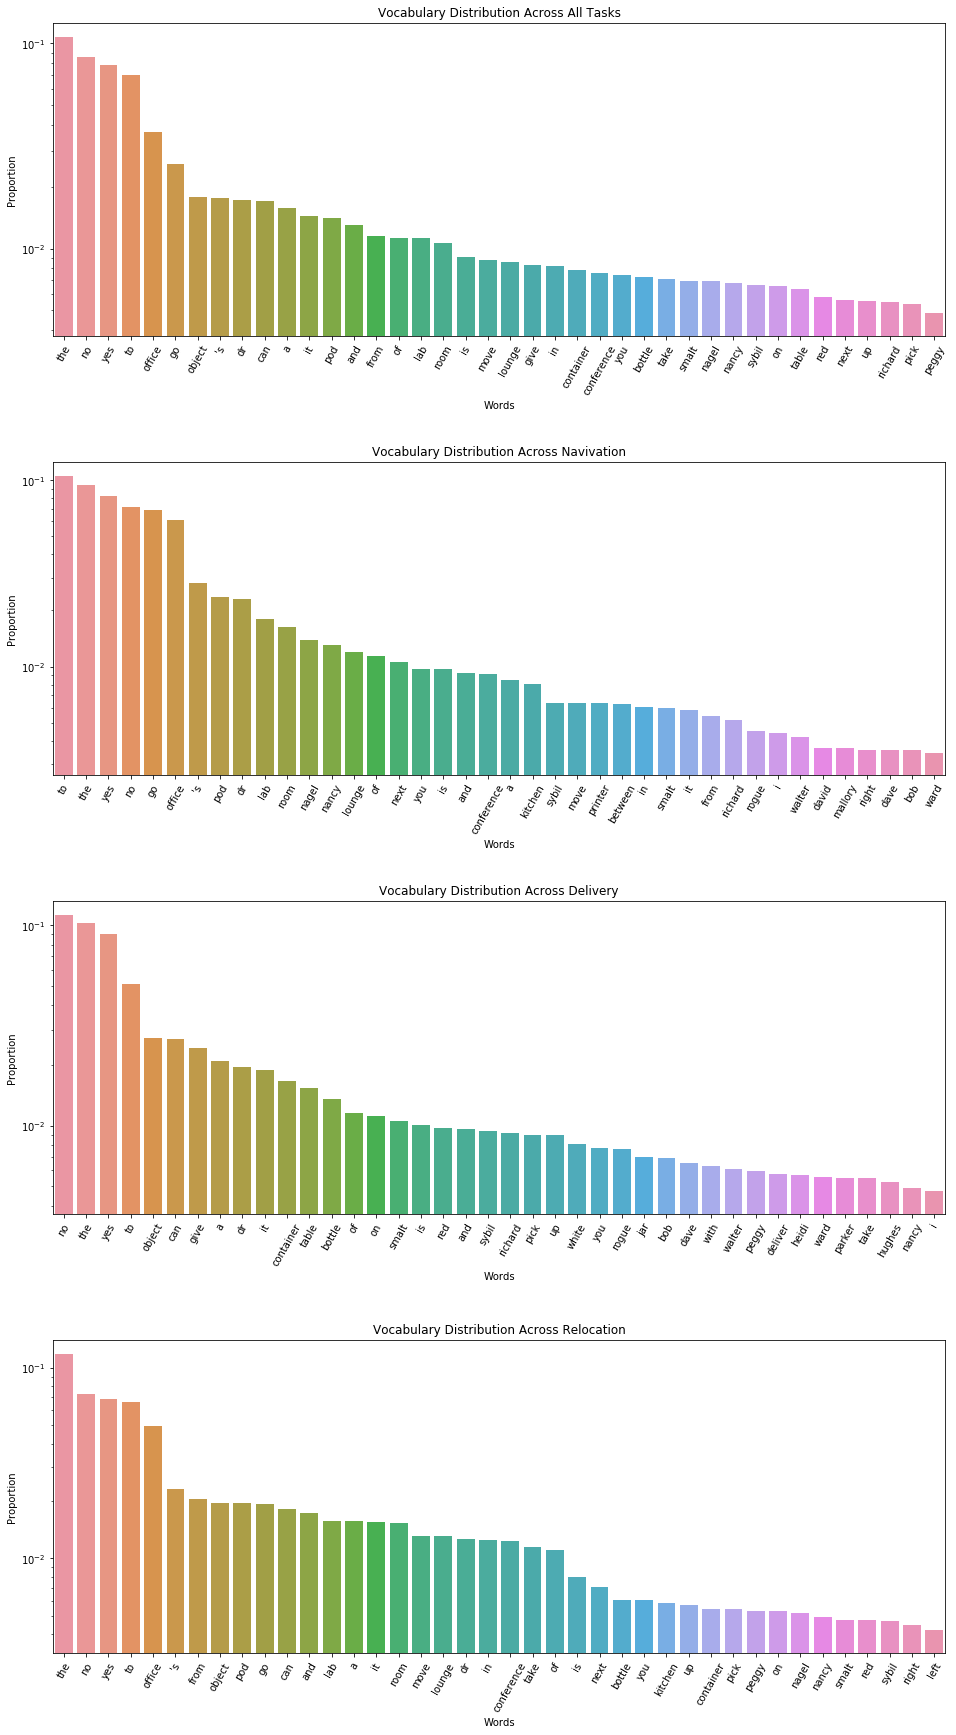

In [150]:
# Show vocabulary count.
norm_all_wc = {st: {token: all_wc[st][token] / all_wc_sum[st] if token in all_wc[st] else 0 for token in all_voc['all']}
               for st in all_wc}
sorted_norms = {st: sorted(norm_all_wc[st].items(), key=lambda kv: kv[1], reverse=True)
                for st in all_wc}

numw = 40
rotation = 60

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(16, 30))
plt.subplots_adjust(hspace = 0.4)
fig.get_axes()[0].set_yscale('log')
fig.get_axes()[1].set_yscale('log')
fig.get_axes()[2].set_yscale('log')
fig.get_axes()[3].set_yscale('log')

ax1.title.set_text('Vocabulary Distribution Across All Tasks')
ax1.set(xlabel='Words', ylabel='Proportion')
g1 = sns.barplot(x=[pair[0] for pair in sorted_norms['all'][:numw]],
            y=np.array([pair[1] for pair in sorted_norms['all'][:numw]]), ax=ax1)
g1.set_xticklabels(ax1.get_xticklabels(), rotation=rotation)

ax2.title.set_text('Vocabulary Distribution Across Navivation')
ax2.set(xlabel='Words', ylabel='Proportion')
g2 = sns.barplot(x=[pair[0] for pair in sorted_norms['nav'][:numw]],
            y=np.array([pair[1] for pair in sorted_norms['nav'][:numw]]), ax=ax2)
g2.set_xticklabels(ax2.get_xticklabels(), rotation=rotation)

ax3.title.set_text('Vocabulary Distribution Across Delivery')
ax3.set(xlabel='Words', ylabel='Proportion')
g3 = sns.barplot(x=[pair[0] for pair in sorted_norms['del'][:numw]],
            y=np.array([pair[1] for pair in sorted_norms['del'][:numw]]), ax=ax3)
g3.set_xticklabels(ax3.get_xticklabels(), rotation=rotation)

ax4.title.set_text('Vocabulary Distribution Across Relocation')
ax4.set(xlabel='Words', ylabel='Proportion')
g4 = sns.barplot(x=[pair[0] for pair in sorted_norms['rel'][:numw]],
            y=np.array([pair[1] for pair in sorted_norms['rel'][:numw]]), ax=ax4)
g4.set_xticklabels(ax4.get_xticklabels(), rotation=rotation)

plt.savefig("voc_dist.pdf",bbox_inches='tight')
plt.show()

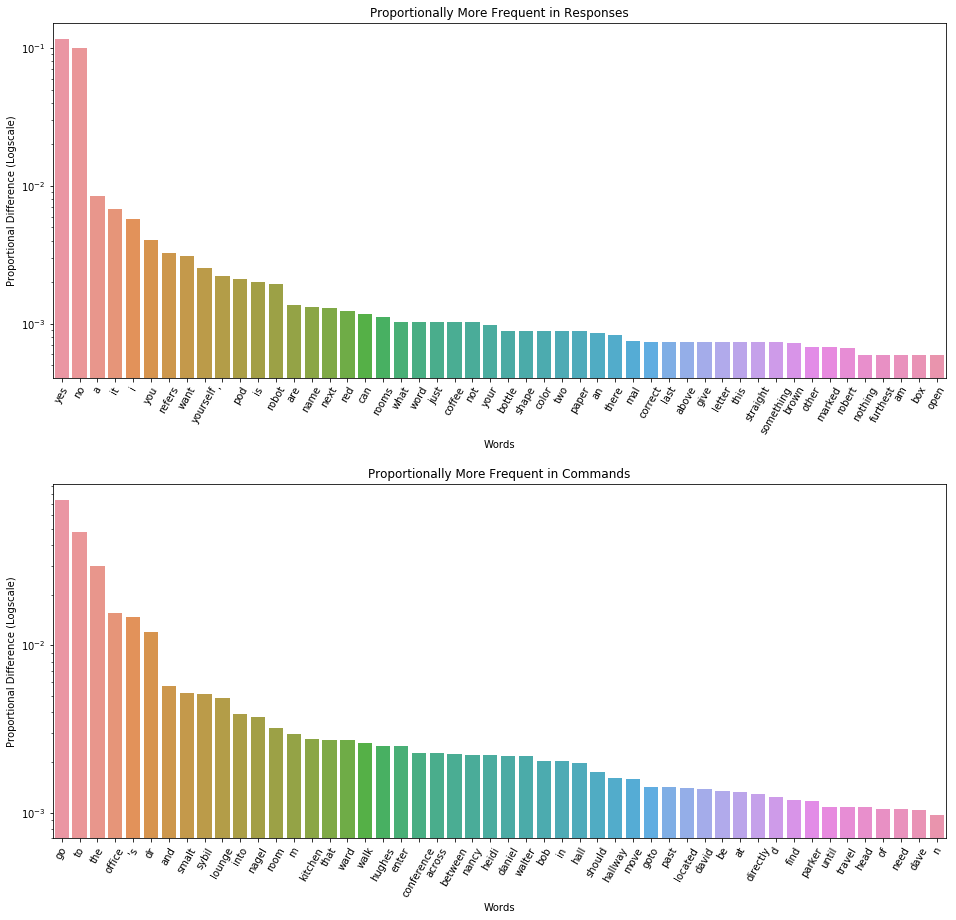

In [169]:
st = 'nav'

# Show contrastive vocabulary by count.
norm_cmd_wc = {token: cmd_wc[st][token] / cmd_wc_sum[st] if token in cmd_wc[st] else 0 for token in all_voc['all']}
norm_res_wc = {token: res_wc[st][token] / res_wc_sum[st] if token in res_wc[st] else 0 for token in all_voc['all']}
sum_res_diffs = {token: norm_cmd_wc[token] - norm_res_wc[token] for token in all_voc['all']}
tk_diffs = sorted(sum_res_diffs.items(), key=lambda kv: kv[1])


numw = 50
rotation = 60

fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, sharey=False, figsize=(16, 15))
plt.subplots_adjust(hspace = 0.3)
fig.get_axes()[0].set_yscale('log')
fig.get_axes()[1].set_yscale('log')

ax1.title.set_text('Proportionally More Frequent in Responses')
ax1.set(xlabel='Words', ylabel='Proportional Difference (Logscale)')
g1 = sns.barplot(x=[pair[0] for pair in tk_diffs[:numw]],
            y=np.array([-pair[1] for pair in tk_diffs[:numw]]), ax=ax1)
g1.set_xticklabels(ax1.get_xticklabels(), rotation=rotation)
ax2.title.set_text("Proportionally More Frequent in Commands")
ax2.set(xlabel='Words', ylabel='Proportional Difference (Logscale)')
g2 = sns.barplot(x=[pair[0] for pair in reversed(tk_diffs[-numw:])],
            y=np.array([pair[1] for pair in reversed(tk_diffs[-numw:])]), ax=ax2)
g2.set_xticklabels(ax2.get_xticklabels(), rotation=rotation)

plt.savefig("cmd_res_diff_%s.pdf" % st,bbox_inches='tight')
plt.show()

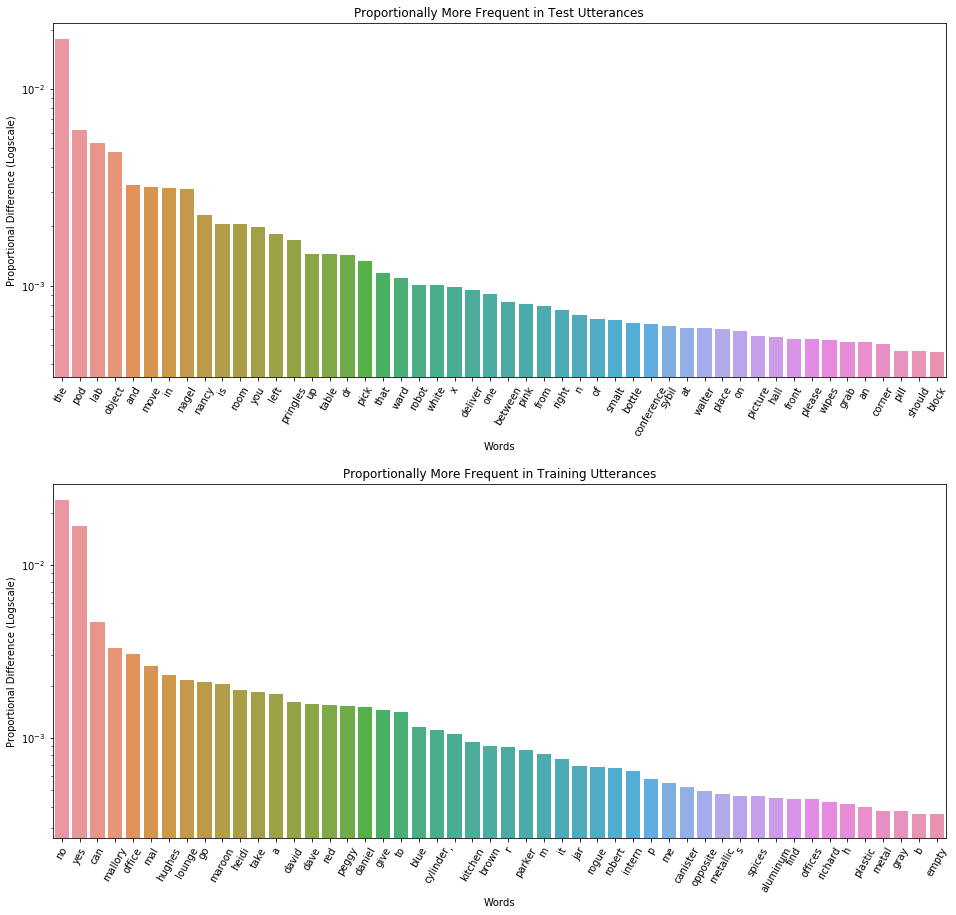

In [8]:
st = 'all'

# Show contrastive vocabulary by count.
norm_train_wc = {token: train_wc[st][token] / train_wc_sum[st] if token in train_wc[st] else 0 for token in all_voc['all']}
norm_test_wc = {token: test_wc[st][token] / test_wc_sum[st] if token in test_wc[st] else 0 for token in all_voc['all']}
sum_test_diffs = {token: norm_train_wc[token] - norm_test_wc[token] for token in all_voc['all']}
tk_diffs = sorted(sum_test_diffs.items(), key=lambda kv: kv[1])


numw = 50
rotation = 60

fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, sharey=False, figsize=(16, 15))
plt.subplots_adjust(hspace = 0.3)
fig.get_axes()[0].set_yscale('log')
fig.get_axes()[1].set_yscale('log')

ax1.title.set_text('Proportionally More Frequent in Test Utterances')
ax1.set(xlabel='Words', ylabel='Proportional Difference (Logscale)')
g1 = sns.barplot(x=[pair[0] for pair in tk_diffs[:numw]],
            y=np.array([-pair[1] for pair in tk_diffs[:numw]]), ax=ax1)
g1.set_xticklabels(ax1.get_xticklabels(), rotation=rotation)
ax2.title.set_text("Proportionally More Frequent in Training Utterances")
ax2.set(xlabel='Words', ylabel='Proportional Difference (Logscale)')
g2 = sns.barplot(x=[pair[0] for pair in reversed(tk_diffs[-numw:])],
            y=np.array([pair[1] for pair in reversed(tk_diffs[-numw:])]), ax=ax2)
g2.set_xticklabels(ax2.get_xticklabels(), rotation=rotation)

plt.savefig("train_test_diff_%s.pdf" % st,bbox_inches='tight')
plt.show()